In [63]:
## Uncomment the following lines if their respective packages are not yet installed:
# install.packages("GGally")   
# install.packages("caret")
# install.packages('e1071', dependencies=TRUE)
library(tidyverse)
library(caret)
library(ggplot2)
library(GGally)
library(repr)
library(purrr)
library(broom)

# Predicting Tennis Match Winners

**Course:** DSCI 100 | Term 2 | 2019W

**Submitted by:**
* Jerry Hall
* Nic Tavares
* Jennifer Zhang
* Huy Pham

# 1 Introduction

The US Open grand slam tennis tournament has an estimated total prize money pool of USD $50.4 million. This puts it in line with high-value tournaments such as the MLB World Series and the PGA FedEx Cup. With such a high potential payoff, there is much incentive for competitive tennis athletes, coaches and potential sponsors to understand the player attributes that contribute to tournament success <sup>1</sup>. 

This project will study the data of tennis match results collected for the top 500 tennis players from 2017-2019. The purpose of the study is to determine whether certain attributes contribute to greater competitive success by analyzing player and match information. In addition, this analysis will also verify the accuracy of hypothesis made by academic scholars. For example, according to Sports Mechanics journal, height significantly affects players' serve speed, which in turn boost his winning chance <sup>2</sup>. Another common claim is there is "prime" age ranging from 27 to 31, in which players perform at their very peak <sup>3</sup>.

We hope to find the answers to these questions by analyzing a comprehensive dataset contains results from nearly 7,000 matches of the top 500 tennis players in different tournaments. This dataset includes match lengths, winner and loser's dominant hands, ages, heights and their number of aces (source: https://github.com/JeffSackmann/tennis_atp). The selection of this attributes is based on the assumed low correlation between variables and the heated controversy surrounding their role in players' performance.



# 2 Methods


### 2.1 Dataset Loading

The tennis player data available on Jeff Sackmann's GitHub<sup>**ADD THIS!!!!**</sup> is split into CSV files per year. To begin, we will use the `read_csv()` function to scrape the data from the web and use `rbind()` to combine the three dataframes into a single one.

In [2]:
data2017 <- read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2017.csv', col_types = cols())
data2018 <- read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2018.csv', col_types = cols())
data2019 <- read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2019.csv', col_types = cols())

combined_data <- rbind(data2017, data2018, data2019)

### 2.2 Wrangling and Cleaning

Next, we select the columns that we are interested in and tidy the data based on whether the given match result was a win or loss.

In [3]:
tennis <- combined_data %>% 
    select(winner_hand, loser_hand, winner_age, loser_age, winner_ht, loser_ht, minutes, w_ace, l_ace)

tennis_win = select(tennis, winner_hand, winner_age, winner_ht, minutes, w_ace)
tennis_loss = select(tennis, loser_hand, loser_age, loser_ht, minutes, l_ace)

tennis_win = mutate(tennis_win, hand = winner_hand, age = winner_age, height = winner_ht, aces = w_ace, result = 'w') %>%
            select(-winner_hand, -winner_age, -winner_ht, -w_ace)
tennis_loss = mutate(tennis_loss, hand = loser_hand, age = loser_age, height = loser_ht, aces = l_ace, result = 'l') %>%
            select(-loser_hand, -loser_age, -loser_ht, -l_ace)

cleaned_data = rbind(tennis_win, tennis_loss)

The match result is then converted to a factor. This allows us to categorize each match winner and loser. The results of this categorization is shown below.

In [4]:
cleaned_data = mutate(cleaned_data, result = as.factor(result))
rows = sample(nrow(cleaned_data))
cleaned_data = cleaned_data[rows, ]

head(cleaned_data)

minutes,hand,age,height,aces,result
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
52,R,23.62765,NA,5,l
58,R,23.84120,NA,4,l
77,R,27.18412,178,1,w
148,R,22.97604,NA,6,w
188,R,22.34908,198,11,l
124,R,27.36756,188,8,l


### 2.3 Splitting and Summarizing

Next, we separate the tidied data into a training_set and a testing_set. The training_set will be given 0.75 of the cleaned_data set; testing_set will be given 0.25. This is so that our model is trained against the training set and we can later perform cross-validation with a testing set to find an optimal k-value.

We will use the `createDataPartition()` function and the `slice()` function to split the data into two sets.

**Note:** We have opted to omit entries containing `NA` values. This is to prevent issues from occurring with our training model later on.

In [5]:
set.seed(42)

training_rows <- cleaned_data %>%
    select(result) %>% 
    unlist() %>%
    createDataPartition (p = 0.75 , list = FALSE)

training_set <- cleaned_data %>% slice (training_rows) %>% na.omit()
testing_set <- cleaned_data %>% slice (-training_rows) %>% na.omit()
head(training_set)

minutes,hand,age,height,aces,result
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
77,R,27.18412,178,1,w
188,R,22.34908,198,11,l
124,R,27.36756,188,8,l
28,R,33.98494,188,1,l
79,R,32.41342,190,6,l
94,L,29.74949,190,6,w


### 2.4 Dataset Visualization

Now that the sets have been partitioned, we plot a matrix of the parameters that which we will later use to perform analysis of predicted player match outcomes.

There are two goals we want to achieve with our visualization:

The correlation between our predicting variables. If one variable is highly correlated to another, we may eliminate them and simplify the modelling process.
The correlation between our predicting variables with our labeling variables.
We achieve this by using the `ggpair()` and `ggcorr()` functions. While `ggpair()` gives us a comprehensive view of how each variable correlates to each other through histograms, box plots, regression model and more, `ggcorr()` provides a more straightforward matrix with results of correlation between variables

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



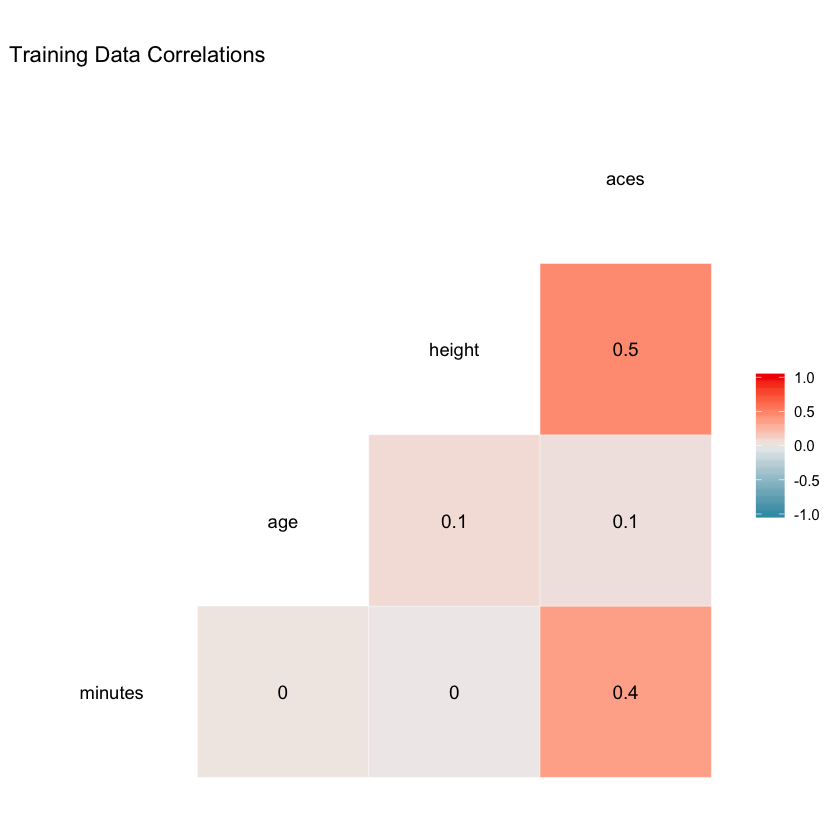

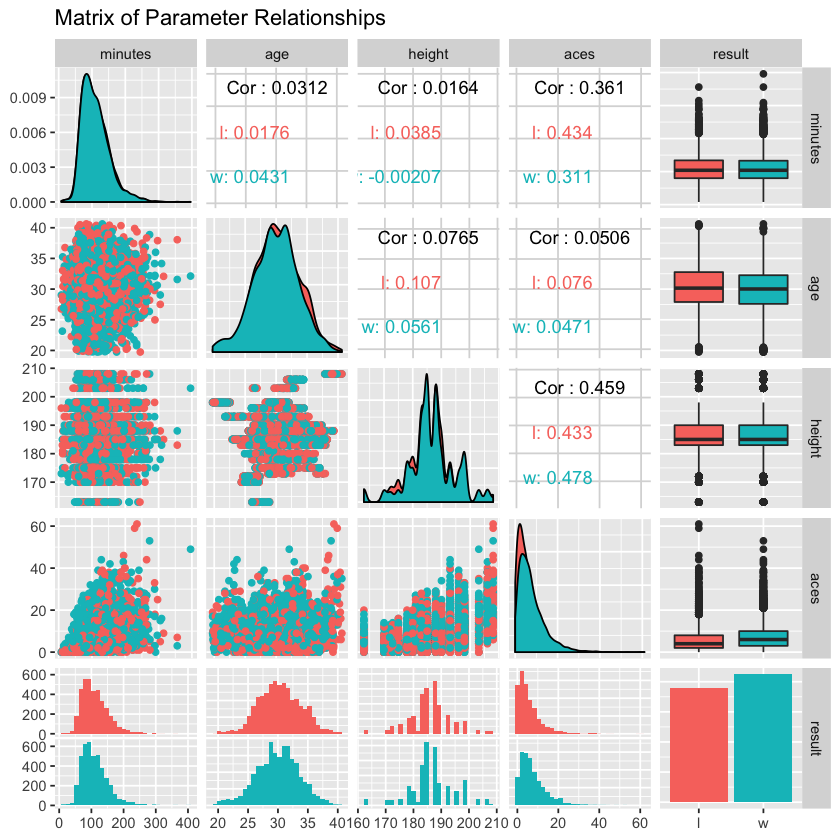

In [29]:
options (repr.plot.width=7, repr.plot.height=7)
tennis_matrix_train <- ggcorr(select(training_set, -hand, -result), label = TRUE,) + labs(title = "Training Data Correlations",)
tennis_matrix_train

training_set2 = select(training_set, -hand)
tennis_train_pairs = ggpairs(training_set2, columns = 1:5, ggplot2::aes(colour=result), progress = FALSE,) + labs(title="Matrix of Parameter Comparisons")
tennis_train_pairs

An intersting point to note is that the histogram distributions for `Minutes`, `Age`, `Height`, and `Aces` do not appear to vary for each `result` outcome. We will keep this in mind when performing our analysis later.

After the first plots we create some basic tables to look at the number of left handed players vs right handed players - which shows that there are way more right handed players which is something to keep in mind later. Then we create a table that shows the mean value of each of the predictor variables we are using.

In [66]:
training_table = group_by(training_set, hand) %>%
    summarize(count = n())
training_table

quantitative_summary_table <- training_set %>%
    select_if(is.numeric)  %>%
    map(~tidy(summary(.x))) %>%  
    do.call(rbind, .) %>%
    t()
quantitative_summary_table

hand,count
<chr>,<int>
L,1208
R,6837


,minutes,age,height,aces
minimum,8.000,19.74264,163.0000,0.00000
q1,80.000,27.71800,183.0000,3.00000
median,104.000,30.08350,185.0000,5.00000
mean,110.405,30.12171,186.3549,6.85606
q3,133.000,32.42984,190.0000,9.00000
maximum,396.000,40.62423,208.0000,61.00000


### 2.5 Classification Model Tuning  

In order to perform k-nn classification we first need to alter the hand column to be numeric and not categorical and then we need to scale our data so that we don't over or under weight certain characteristics based on the unit they were measured in. We have arbitrarily chosen 1 to represent right handed and 0 to represent left handed.

In [8]:
training_data_scaled = training_set %>% mutate(hand = ifelse(hand == "R", 1, 0))

training_data_scaled = training_data_scaled %>% 
                        mutate(minutes = scale(minutes, center = TRUE)) %>%
                        mutate(age = scale(age, center = TRUE)) %>%
                        mutate(height = scale(height, center = TRUE)) %>%
                        mutate(aces = scale(aces, center = TRUE))

testing_data_scaled = testing_set %>% mutate(hand = ifelse(hand == "R", 1, 0))

testing_data_scaled = testing_data_scaled %>% 
                        mutate(minutes = scale(minutes, center = TRUE)) %>%
                        mutate(age = scale(age, center = TRUE)) %>%
                        mutate(height = scale(height, center = TRUE)) %>%
                        mutate(aces = scale(aces, center = TRUE))



head(training_data_scaled)
head(testing_data_scaled)
                    

minutes,hand,age,height,aces,result
"<dbl[,1]>",<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
-0.8101891,1,-0.8256972,-1.0621298,-0.9738980,w
1.8819549,1,-2.1847295,1.4804082,0.6891622,l
0.3297277,1,-0.7741371,0.2091392,0.1902442,l
-1.9986131,1,1.0858749,0.2091392,-0.9738980,l
-0.7616820,1,0.6441509,0.4633930,-0.1423679,l
-0.3978788,0,-0.1046251,0.4633930,-0.1423679,w


minutes,hand,age,height,aces,result
"<dbl[,1]>",<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
1.1763658,1,-1.44874564,-2.1184294,-0.9323594,l
0.5805232,0,-0.65155293,-0.1587225,1.1622554,l
-0.7175626,1,0.05673075,1.2783960,1.4845038,l
-1.1218844,0,0.21213476,-0.4200167,-0.6101109,w
0.1762014,1,0.70001371,0.8864546,0.0343859,w
0.2613218,1,-0.83011812,-1.0732524,-0.6101109,w


Now we will split the data into:
* X_train
* X_test
* Y_train
* Y_test


In [9]:
X_train = training_data_scaled %>%
        select(-result) %>%
        data.frame()

Y_train = training_data_scaled %>%
        select(result) %>%
        unlist()

X_test = testing_data_scaled %>%
        select(-result) %>%
        data.frame()

Y_test = testing_data_scaled %>%
        select(result) %>%
        unlist()
            

Now we will be using our training data to build a model. First thing we need to do is choose a number k that represents the number of neighbors we will be examining in order to determine the classification of a new data point. We will be evaluating k in the range of 1:20 and using 10 fold cross validation.

In [10]:
ks = data.frame(k = c(1:20))
train_control <- trainControl(method = "cv", number = 10)
choose_k = train(x = X_train, y = Y_train, method = "knn", tuneGrid = ks, trControl = train_control)
choose_k


k-Nearest Neighbors 

8045 samples
   5 predictor
   2 classes: 'l', 'w' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7240, 7241, 7240, 7240, 7241, 7240, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa     
   1  0.5520186  0.10087850
   2  0.5489171  0.09475503
   3  0.5659431  0.12793677
   4  0.5589790  0.11374606
   5  0.5685512  0.13170997
   6  0.5680560  0.13077090
   7  0.5806094  0.15631985
   8  0.5671852  0.12881601
   9  0.5740217  0.14213719
  10  0.5806117  0.15520661
  11  0.5803619  0.15453677
  12  0.5799879  0.15379320
  13  0.5791162  0.15167188
  14  0.5751387  0.14393556
  15  0.5834687  0.16044342
  16  0.5857072  0.16507838
  17  0.5824766  0.15840575
  18  0.5808571  0.15511260
  19  0.5783729  0.14994075
  20  0.5808591  0.15527937

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 16.

Now we can plot the accuracies for our various k values.

,k,Accuracy
,<int>,<dbl>
1,1,0.5520186
2,2,0.5489171
3,3,0.5659431
4,4,0.5589790
5,5,0.5685512
6,6,0.5680560


,k,Accuracy
,<int>,<dbl>
15,15,0.5834687
16,16,0.5857072
17,17,0.5824766
18,18,0.5808571
19,19,0.5783729
20,20,0.5808591


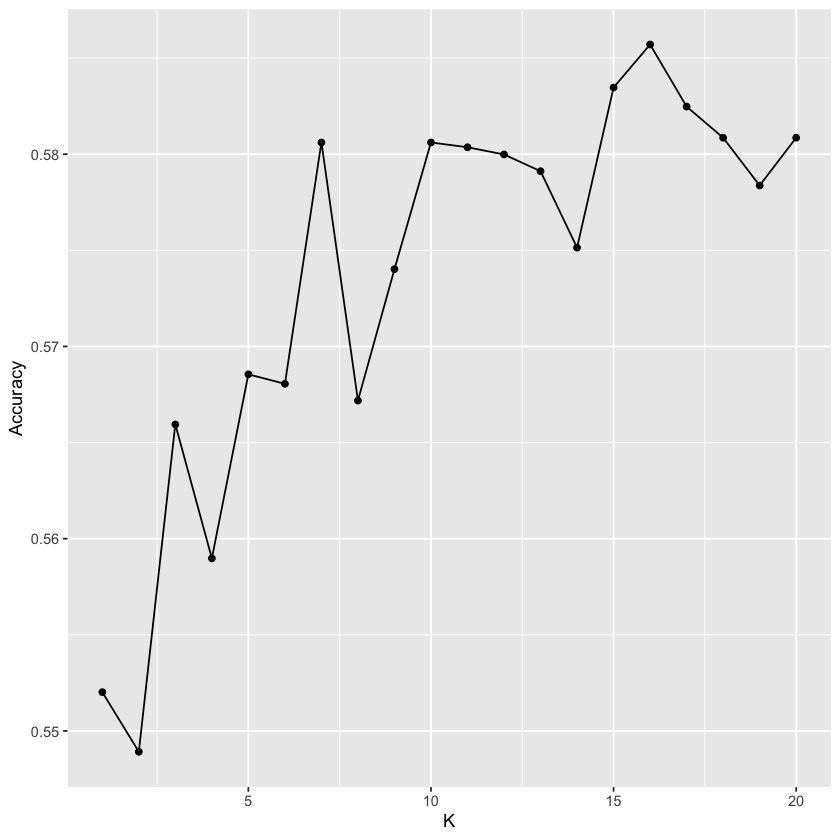

In [48]:
k_accuracies_again <- choose_k$results %>% select(k, Accuracy)
head(k_accuracies_again)
tail(k_accuracies_again)
choose_k_again_plot <- ggplot(k_accuracies_again, aes(x = k, y = Accuracy)) +
                          geom_line() +
                          geom_point() +
                            labs(x = "K", y = "Accuracy")


# your code here
choose_k_again_plot

As seen in the plot above, `k = 12` gives us the highest accuracy out of the values we tested. 

=> Choose `k = 12` for our model.

### 2.6 Classification Model Evaluation

We will retrain our model and assign the trained model to `final_classifier`.

In [56]:
final_k = data.frame(k = 12)
final_classifier <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = final_k)
# final_classifier

Now, we can test the accuracy of our model using the testing set data that we split off earlier.

In [58]:
test_pred <- predict(final_classifier, X_test)
test_results <- confusionMatrix(test_pred, Y_test)
test_results$overall[1]
test_results

Accuracy 
0.5720637

Confusion Matrix and Statistics

          Reference
Prediction   l   w
         l 634 520
         w 635 910
                                          
               Accuracy : 0.5721          
                 95% CI : (0.5531, 0.5908)
    No Information Rate : 0.5298          
    P-Value [Acc > NIR] : 5.754e-06       
                                          
                  Kappa : 0.1367          
                                          
 Mcnemar's Test P-Value : 0.0007954       
                                          
            Sensitivity : 0.4996          
            Specificity : 0.6364          
         Pos Pred Value : 0.5494          
         Neg Pred Value : 0.5890          
             Prevalence : 0.4702          
         Detection Rate : 0.2349          
   Detection Prevalence : 0.4276          
      Balanced Accuracy : 0.5680          
                                          
       'Positive' Class : l               
                              

# 3 Discussion

### 3.1 Summary

The success rate that our classification model had at correctly predicting the match outcome from our training data was `57.21%`. This accuracy is only marginally more significant than a coin flip (ie. 50% chance) and is not enough such that we could recommend its use for predicting successful matches. 

We were also interested in determining whether certain attributes contributed towards greater match success. As we saw in the Matrix of Parameter Comparisons in **2.4 Dataset Visualization**, there was not a significant correlation of `Minutes`, `Age`, `Height`, `Aces` with `Result`. This is further supported by 

### 3.2 Expectations

Going into this project our expectations were that certain attributes would contribute to greater success in tennis. For example, as mentioned earlier in this report - age could have been a key variable that determined success. However, given the fact that our model only performs slightly better than a coin flip (figure x) and more specifically the distributions of ages are almost identically distributed between winners and losers (figure y) it appears that our expected results and actual results are not in line with one another.

### 3.3 Significance and Future Research

If our original expectations of this research had turned out to be correct it could have been an extremely useful tool for coaches to evaluate the prospects of up and coming players as well as companies looking to get early and high value sponsorships with up and coming players. However, it seems like predicting tennis match outcomes, if possible at all, will require much more in depth analysis of variables. Future research might take into account more quantitative variables such as play style and pair them with the variables that were used in this research to examine the ways that players' playstyles change based on the various physical attributes of the player and further examine how these things affect tennis match re

# References

<sup>1</sup> 10 Sporting events with the most prize money. (2017, September 10). PledgeSports. Retrieved from: https://www.pledgesports.org/2017/09/10-sporting-events-with-the-biggest-prize-money/

<sup>2</sup> Vaverka, Frantisek & Cernosek, Miroslav (2013). Association between body height and serve speed in elite tennis players. Sports Biomech, 12, 30-7, DOI: 10.1080/14763141.2012.670664. 

<sup>3</sup> César Gallo-Salazar, Juan José Salinero, David Sanz, Francisco Areces & Juan del Coso (2015). Professional tennis is getting older: Age for the top 100 ranked tennis players. International Journal of Performance Analysis in Sport, 15:3, 873-883, DOI: 10.1080/24748668.2015.11868837